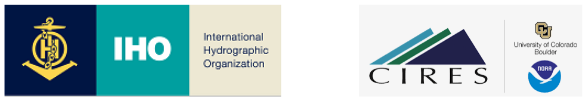


## Crowdsourced Bathymetry Data (CSB) Visualization

CSB is a citizen science project supported by the IHO and NOAA. This notebook will send an extract request to a data lake of crowdsourced bathymetry data stored as csv files on s3 and available through an AWS Athena service stored in parquet format. After generating a subset of the data within our geographic bounding box we can visualize the results as a 3D plot. The data lake hosted by the NOAA Big Data Project contains nearly 100,000,000 unique depth soundings from over 135 participating ships!

Read more here: https://noaa-bathymetry-pds.s3.amazonaws.com/readme.html

Or browse the bucket here: https://noaa-bathymetry-pds.s3.amazonaws.com/index.html

This notebook is available here:
https://github.com/dneufeldcu/notebooks/blob/main/esipCSBWinterDemo2021.ipynb

Next time do this...
conda activate base
conda config --add channels conda-forge --force
conda install mamba
mamba update --yes --all
mamba create -n holoviz datashader geoviews hvplot

### Step 1. 
Let's install numby and matplot to support the visualization, and smart-open in order to read the csv file from s3.

In [63]:
import sys
!{sys.executable} -m pip install ipyleaflet
import sys
!{sys.executable} -m pip install numpy
import sys
!{sys.executable} -m pip install matplotlib
import sys
!{sys.executable} -m pip install smart-open
import sys
!{sys.executable} -m pip install pandas
import sys
!{sys.executable} -m pip install hvplot
import sys
!{sys.executable} -m pip install proj
import sys
!{sys.executable} -m pip install cartopy
import sys
!{sys.executable} -m pip install geoviews
import sys
!{sys.executable} -m pip install pykdtree
import sys
!{sys.executable} -m pip install pyproj
import sys
!{sys.executable} -m pip install xarray
import sys
!{sys.executable} -m pip install datashader
print("Libraries installed.")



You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 736 kB 1.1 MB/s eta 0:00:01


You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
     |████████████████████████████████| 15.8 MB 5.6 MB/s eta 0:00:01
     |████████████████████████████████| 891 kB 61.3 MB/s eta 0:00:01
     |████████████████████████████████| 76 kB 8.5 MB/s  eta 0:00:01
     |████████████████████████████████| 672 kB 13.0 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 4.0 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 2.8 MB/s eta 0:00:01
     |████████████████████████████████| 2.1 MB 1.3 MB/s eta 0:00:01
     |████████████████████████████████| 107 kB 2.5 MB/s eta 0:00:01
     |████████████████████████████████| 236 kB 6.1 MB/s eta 0:00:01
     |████████████████████████████████| 55 kB 7.7 MB/s  eta 0:00:01
     |████████████████████████████████| 30.9 MB 5.8 MB/s eta 0:00:01
Using legacy 'setup.py install' for datashape, since package 'wheel' is not installed.
Using legacy 'setup.py install

You should consider upgrading via the '/usr/local/Cellar/jupyterlab/3.0.5/libexec/bin/python3 -m pip install --upgrade pip' command.
Libraries installed.


### Step 2.
Import the required libraries

In [21]:
import time
import csv
import requests
import numpy as np
import matplotlib.pyplot as plt
from smart_open import open as sm_open
from ipyleaflet import Map, WMSLayer, basemaps



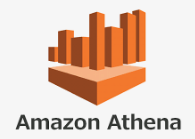
### Step 3.
Write a generic HTTP request. We'll populate the url with our Athena service endpoint and our JSON payload will contain our extract parameters.


In [22]:
def extract_request(url, payload):
    # Use a breakpoint in the code line below to debug your script.
    print(f'Request url: {url}')  # Press ⌘F8 to toggle the breakpoint.
    print(f'Payload: {payload}')
    r = requests.post(url, json=payload)
    print(r.status_code)
    return r.json()


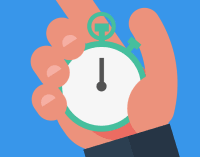
### Step 4.
Because our extract service is ansychronous we'll need poll the job status endpoint for status

In [23]:
def job_status(response):
    time.sleep(3)
    # Use a breakpoint in the code line below to debug your script.
    response_url = response['url']
    print(f'Response url: {response_url}')  # Press ⌘F8 to toggle the breakpoint.

    r = requests.get(response_url)
    return r

### Step 5.
Our main execution flow let's submit an extract request for depth soundings near the San Diego airport based on the extent of our map.


In [24]:
center = (32.715,-117.209)

map = Map(basemap=basemaps.Esri.NatGeoWorldMap, center=center, zoom=9)

wms = WMSLayer(
    url='https://gis.ngdc.noaa.gov/arcgis/services/csb/MapServer/WMSServer',
    layers='1',
    format='image/png',
    transparent=True,
)
map.add_layer(wms)
display(map)


Map(center=[32.715, -117.209], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zo…

In [25]:
# Grab the geographic extent from the map bounds

extent = f"{map.bounds[0][1]},{map.bounds[0][0]},{map.bounds[1][1]},{map.bounds[1][0]}"
print (extent)
payload = {}
payload['email'] = "david.neufeld@noaa.gov"
payload['bbox'] = extent
print(str(payload))

# Submit to the Athena service
response = extract_request('https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request', payload)
status_response = job_status(response)
while status_response.status_code == 404:
    print("sleeping...")
    time.sleep(3)
    status_response = job_status(response)
    print(status_response.status_code)


job_payload = status_response.json()
print(job_payload['status'])
while str(job_payload['status']) == "RUNNING":
    print(f"Job is still {job_payload['status']}")
    print("sleep...")
    time.sleep(3)
    status_response = job_status(response)
    job_payload = status_response.json()
    print(status_response.status_code)

print(job_payload['url'])
s3_url = job_payload['url']

-117.52664944540068,32.55490031285473,-116.8530502022366,32.786104227208554
{'email': 'david.neufeld@noaa.gov', 'bbox': '-117.52664944540068,32.55490031285473,-116.8530502022366,32.786104227208554'}
Request url: https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request
Payload: {'email': 'david.neufeld@noaa.gov', 'bbox': '-117.52664944540068,32.55490031285473,-116.8530502022366,32.786104227208554'}
201
Response url: https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request/ced1ead4-1758-4c96-aeae-3b3487d6e437
RUNNING
Job is still RUNNING
sleep...
Response url: https://q20bz02j8b.execute-api.us-east-1.amazonaws.com/extract-request/ced1ead4-1758-4c96-aeae-3b3487d6e437
200
https://csb-pilot-delivery.s3.amazonaws.com/ced1ead4-1758-4c96-aeae-3b3487d6e437.csv


In [26]:
# Let's use smart_open to read directly from our s3 object
# Read more about smart_open here - https://pypi.org/project/smart-open/
def get_csv_s3(url):
    sm_open_file = sm_open(url, 'r')
    return sm_open_file

In [27]:
# Lastly let's visualize our data
# Are there outliers
def visualize(s3_url):
    # Read CSV
    csv_data = []
    csv_file = get_csv_s3(s3_url)

    csv_reader = csv.reader(csv_file, delimiter=',')
    i = 0
    for csv_row in csv_reader:
        if i > 0:
            csv_data.append([csv_row[0], csv_row[1], csv_row[2]])
        i = i + 1

    # Get X, Y, Z
    csv_data = np.array(csv_data)
    csv_data = csv_data.astype( np.float )
    x, y, z = csv_data[:, 0], csv_data[:, 1], (csv_data[:, 2] * -1)

    # Plot X,Y,Z
    fig = plt.figure()
    ax = fig.add_subplot( 111, projection='3d' )
    ax.plot_trisurf(x, y, z, color='white', edgecolors='grey', alpha=0.5)
    ax.scatter(x, y, z, c = 'red')
    plt.show()

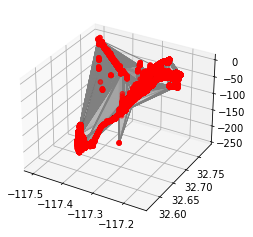

In [28]:
    # Now visualize the file
    visualize(s3_url)

In [ ]:
print("Thank you, any questions?!")

In [65]:
import pandas as pd
import hvplot.pandas
import cartopy
import geoviews
import pykdtree
import pyproj
import xarray


df.head()

,lon,lat,depth,time,platform,provider
0,-117.19086,32.725850,3.44,2020-06-10 22:21:44.000,Copper Star,Rose Point
1,-117.19087,32.725792,3.44,2020-06-10 22:22:28.000,Copper Star,Rose Point
2,-117.19087,32.725770,3.44,2020-06-10 22:22:30.000,Copper Star,Rose Point
3,-117.19088,32.725758,3.44,2020-06-10 22:22:32.000,Copper Star,Rose Point
4,-117.19086,32.725834,3.47,2020-06-10 22:24:35.000,Copper Star,Rose Point


In [66]:
df.hvplot.points(x='lon', y='lat', color='depth', rasterize=True, 
                 geo=True, cmap='jet', frame_width=600, tiles='OSM', hover=False)


ImportError: Datashading is not available